In [638]:
from torchvision import transforms
from torch.utils.data import random_split
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from torch import nn
import torch.nn.functional as F
import torch
from torch.optim import Adam

import matplotlib.pyplot as plt
import pandas as pd
from skimage import io
from tqdm import tqdm
import os

In [639]:
### Parameters
batch_size = 10
crop_size = 256
image_size = 100

### Hyperparams
learning_rate = 0.002
betas = (0.7, 0.999)

In [640]:
class GZ2Dataset(Dataset):
    def __init__(self, csv_file_maps: str, csv_file_data: str, root_dir: str, transform = None) -> None:
        """
        Initializes the dataset.

        Parameters:
            csv_file_maps (str): Name of *.csv file that contains the filename to id mapping for the images
            csv_file_data (str): Name of *.csv file that contains the labeled data for every id
            root_dir (str): Directory containing all the images
            transform (class from torchvision.transforms): Transform to be used on the image data
        """
        self.maps = pd.read_csv(csv_file_maps)
        self.data = pd.read_csv(csv_file_data)[:10000]
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self) -> int:
        """
        Returns the size of the dataset as number of elements.

        Returns:
            int: Number of elements
        """
        return len(self.data)
    
    def __getitem__(self, index: int) -> tuple:
        """
        Returns an element from the dataset for a given index.

        Parameters:
            index (int): The index of the element to be returned

        Returns:
            tuple: Tuple in the form of (image_data: torch.Tensor, datapoint_1, datapoint_2, ...)

        """
        # Value of the "dr7objid" field for the current element
        dr7objid = self.data['dr7objid'][index]

        filename = str(self.maps[self.maps['objid'] == dr7objid]['asset_id'].item()) + '.jpg'
        image_path = os.path.join(self.root_dir, filename)
        image = io.imread(image_path) # Load image as numpy tensor with normalized color values

        # pandas Dataframe containing all the datapoints for the given dr7objid
        image_data = self.data.loc[self.data['dr7objid'] == dr7objid]

        # Select prediction (for t01) from maximum percentage of votes 
        predictions = [image_data.to_numpy()[0][13], image_data.to_numpy()[0][19], image_data.to_numpy()[0][25]]
        prediction = predictions.index(max(predictions))

        # Possible predictions:
        # 0:= smooth
        # 1:= features
        # 2:= star

        if self.transform:
            image = self.transform(image)

        output = [image, prediction]

        return tuple(output)

In [641]:
transform = transforms.Compose([transforms.ToTensor(), transforms.CenterCrop(crop_size), transforms.Resize(image_size)]) # Transforms to be used on the data

dataset = GZ2Dataset(csv_file_maps='gz2_filename_mapping.csv', csv_file_data='gz2_hart16_cleaned.csv', root_dir='images_gz2/images/', transform=transform)

# Split dataset into training and testing data using 80% of the dataset for training and 20% for testing 
trainset, testset = random_split(dataset, [round(0.8*len(dataset)), round(0.2*len(dataset))])

In [642]:
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=True)

In [643]:
class CNN_T01(nn.Module):
    def __init__(self):
        super(CNN_T01, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, (3,3))
        self.conv2 = nn.Conv2d(32, 64, (3,3))
        #self.conv3 = nn.Conv3d(16, 28, (1,5,5))

        self.drop1 = nn.Dropout(0.15)

        self.l3 = nn.Linear(32*49*49, 128)

        self.drop2 = nn.Dropout(0.15)

        self.l4 = nn.Linear(128, 128)
        self.out = nn.Linear(128,3)
    
    def forward(self, x):
        x = self.conv1(x)
        #x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, (2,2))
        #x = F.max_pool2d(self.conv1(x), (2,2))
        #x = F.max_pool2d(self.conv2(x), (2,2))
        #x = F.max_pool3d(self.conv3(x), (1,3,3))

        #print(x.shape)

        x = x.reshape(batch_size,32*49*49)

        #x = self.drop1(x)

        x = self.drop2(F.relu(self.l3(x)))
        x = F.relu(self.l4(x))
        x = self.out(x)
        return x

In [644]:
net_t01 = CNN_T01()

optimizer = Adam(net_t01.parameters(), lr=learning_rate, betas=betas)
criterion = nn.CrossEntropyLoss()

In [645]:
epochs = 3

training_losses = []
test_losses = []

for epoch in range(epochs):
    #Training
    training_loss = 0

    trainloop = tqdm(trainloader)

    for i, (images, labels) in enumerate(trainloop):
        images = images.reshape(batch_size,3,image_size,image_size)

        optimizer.zero_grad() #Set gradients to zero
        
        predictions = net_t01(images)

        loss = criterion(predictions, labels)
        loss.backward()
        
        optimizer.step()
        
        training_loss += loss.item()

        trainloop.set_description(f"Epoch [{epoch+1}/{epochs}]")
        trainloop.set_postfix(loss=training_loss/(i+1))
    
    training_losses.append(training_loss/len(trainloader))
    
    #Test
    test_loss = 0
    accuracy = 0

    testloop = tqdm(testloader)

    for i, (images,labels) in enumerate(testloop):
        images = images.reshape(batch_size,3,image_size,image_size)
        with torch.no_grad():
            test_predictions = net_t01(images)
            
            test_loss += criterion(test_predictions, labels)
                    
            top_probability, top_guess = test_predictions.topk(1, dim=1) #Tensor of top guesses for each image
            guess_correct = top_guess == labels.view(top_guess.shape) #Tensor of booleans for each guess (True: correct guess, False: wrong guess)
            accuracy += torch.mean(guess_correct.type(torch.FloatTensor)) #Calculate mean of booleans (True:=1.0, False:=0.0)
        
        testloop.set_description(f"> Validation on test data ")
        testloop.set_postfix(loss=test_loss.item()/(i+1),acc=accuracy.item()/(i+1))

    test_losses.append(test_loss.tolist()/len(testloader))

> Validation on test data : 100%|██████████| 200/200 [00:13<00:00, 14.94it/s, acc=0.839, loss=0.377]


2000
Guess: featured
Label: featured


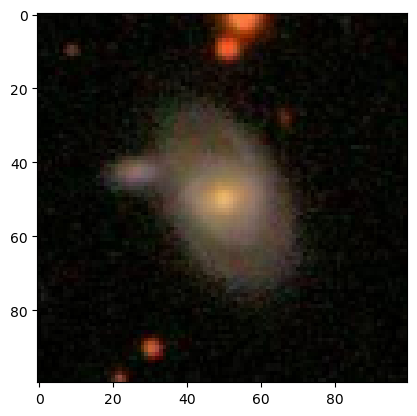

In [667]:
image, label = next(iter(testloader))

print(len(testset))

prediction = net_t01(image.reshape(batch_size,3,image_size,image_size))

plt.imshow(image[0].permute(1,2,0).numpy())

#print(prediction.topk(1,dim=1)[1][0])

print('Guess: ' + ['smooth', 'featured', 'star'][prediction.topk(1,dim=1)[1][0].item()])
print('Label: ' + ['smooth', 'featured', 'star'][label[0].item()])